# Inverted pendulum on cart model

Equations:

$$
\begin{cases}
\ddot{x} + \alpha\cos\theta\,\ddot{\theta} + \alpha\sin\theta\,\dot{\theta}^2 &= u \\
-\cos\theta\,\ddot{x} + \ddot{\theta} &= \sin\theta
\end{cases},
$$

where $\alpha < 1$ is the ratio of the pendulum mass over the total system mass.

We now define the system dynamics in CasADi

In [18]:
import horizon.solvers.ilqr as ilqr
import casadi as cs
import numpy as np

# switch between MX and SX
sym_t = cs.MX

# define state
x = sym_t.sym('x', 3)
u = sym_t.sym('u', 2)
xdot = cs.vertcat( u[0] * cs.cos(x[2]), 
                   u[0] * cs.sin(x[2]),
                   u[1])

## Optimal control problem

We optimize the following cost
$$
    J(\boldsymbol{x}_0, \mathbf{U}) = \int_0^{t_f} u^2 \,\text{d}t \; + \; 1000\cdot\lVert \boldsymbol{x}_N - \boldsymbol{x}_f^\text{ref}  \rVert^2
$$

discretized with $N$ knots of duration $\text{d}t$.

In [19]:
N = 50  # number of nodes
dt = 0.1  # discretizaton step
niter = 70  # ilqr iterations
x0 = np.array([0, 0, 0])  # initial state (falling)
xf = np.array([0, 1, 0])  # desired final state (upright)

obs_center = np.array([0.05, 0.5])
obs_r = 0.1
obs = -cs.sumsqr(x[0:1] - obs_center) + obs_r  # obs(x) < 0


def barrier(x):
    
    return 0.5*(x + 0.001*cs.sqrt((x*1000)**2 + 1e-9))
    

l = cs.sumsqr(u) # intermediate cost
lf = 0  #1000*cs.sumsqr(x - xf)  # final cost
gf = x - xf

Costs and dynamics must be expressed as CasADi functions

In [20]:
L = cs.Function('intermediate_cost',
                {'x': x, 'u': u, 'l': l},
                ['x', 'u'],
                ['l']
                )

Xdot = cs.Function('dynamics',
                {'x': x, 'u': u, 'xdot': xdot},
                ['x', 'u'],
                ['xdot']
                )


Lf = cs.Function('final_cost',
                {'x': x, 'l': lf},
                ['x'],
                ['l']
                )

Gf = cs.Function('final_constr',
                {'x': x, 'gf': gf},
                ['x'],
                ['gf']
                )


solver = ilqr.IterativeLQR(xdot=Xdot,
                           dt=dt,
                           N=N,
                           diff_intermediate_cost=L,
                           final_cost=Lf,
                           final_constraint=Gf)

solver.setInitialState(x0)
solver.randomizeInitialGuess()
solver.solve(niter)

dyn_err = 1.6e+02, du = 2e+02, dx = 1.7e+02
dyn_err = 5.8, du = 1.5e+03, dx = 9e+01
dyn_err = 0.89, du = 2.2e+02, dx = 2.8e+01
dyn_err = 0.084, du = 3.7e+01, dx = 2.3e+01
dyn_err = 0.31, du = 2e+01, dx = 1.8e+01
dyn_err = 0.21, du = 1.9e+01, dx = 1.5e+01
dyn_err = 0.14, du = 1.1e+01, dx = 1.2e+01
dyn_err = 0.11, du = 9.5, dx = 1e+01
dyn_err = 0.071, du = 7.0, dx = 8.5
dyn_err = 0.047, du = 6.2, dx = 7.0
dyn_err = 0.031, du = 4.8, dx = 5.7
dyn_err = 0.02, du = 4.0, dx = 4.6
dyn_err = 0.014, du = 3.2, dx = 3.8
dyn_err = 0.0089, du = 2.7, dx = 3.1
dyn_err = 0.006, du = 2.2, dx = 2.6
dyn_err = 0.004, du = 1.8, dx = 2.1
dyn_err = 0.0027, du = 1.5, dx = 1.8
dyn_err = 0.0018, du = 1.3, dx = 1.5
dyn_err = 0.0013, du = 1.1, dx = 1.3
dyn_err = 0.00092, du = 0.91, dx = 1.1
dyn_err = 0.00067, du = 0.78, dx = 1.0
dyn_err = 0.0005, du = 0.68, dx = 0.88
dyn_err = 0.00038, du = 0.6, dx = 0.8
dyn_err = 0.00029, du = 0.53, dx = 0.7
dyn_err = 0.00023, du = 0.47, dx = 0.65
dyn_err = 0.00018, du = 0.42, dx

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

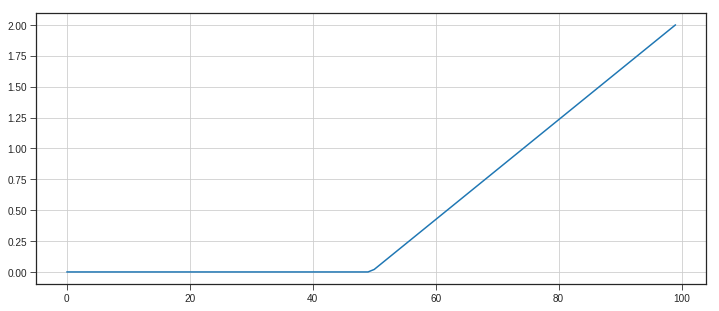

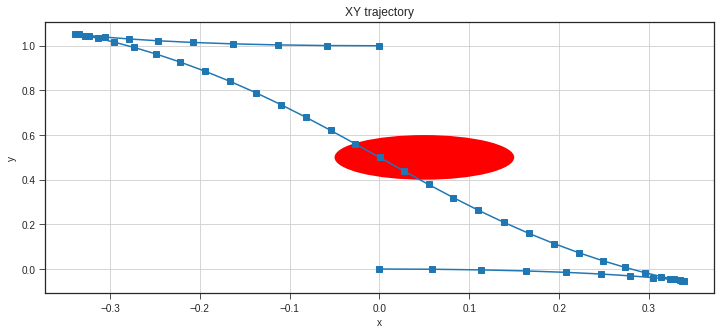

In [22]:
plt.figure(figsize=[12, 5])
lines = plt.plot(barrier(np.linspace(-2, 2, num=100)))
plt.grid()
# plt.legend(lines, ['x', 'y', r'$\theta$'])

plt.figure(figsize=[12, 5])
xtrj = np.column_stack(solver._state_trj)
lines = plt.plot(xtrj[0,:], xtrj[1,:], 's-')
circle = plt.Circle(obs_center, radius=obs_r, fc='r')
plt.gca().add_patch(circle)
plt.title('XY trajectory')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
# plt.legend(lines, ['x', 'y', r'$\theta$'])

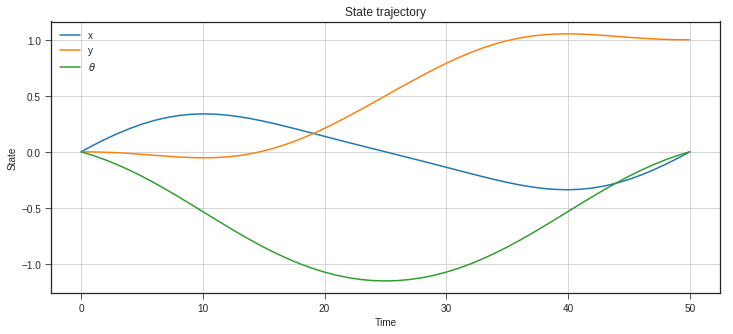

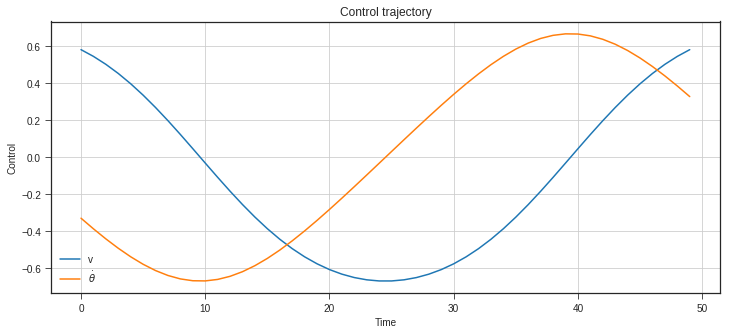

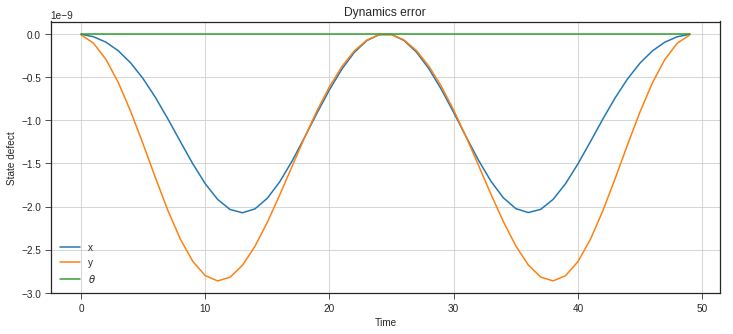

In [23]:
plt.figure(figsize=[12, 5])
lines = plt.plot(solver._state_trj)
plt.title('State trajectory')
plt.xlabel('Time')
plt.ylabel('State')
plt.grid()
plt.legend(lines, ['x', 'y', r'$\theta$'])

plt.figure(figsize=[12, 5])
lines = plt.plot(solver._ctrl_trj)
plt.title('Control trajectory')
plt.xlabel('Time')
plt.ylabel('Control')
plt.grid()
plt.legend(lines, ['v', r'$\dot{\theta}$'])

plt.figure(figsize=[12, 5])
lines = plt.plot(solver._defect)
plt.title('Dynamics error')
plt.xlabel('Time')
plt.ylabel('State defect')
plt.grid()
plt.legend(lines, ['x', 'y', r'$\theta$'])


## ROS visualization
The following code visualizes the result in RViz. In separate terminals, open RViz and the Robot State Publisher

In [17]:
import rospy
import sensor_msgs.msg
import math

rospy.init_node('inv_pendulum_joint_publisher')

with open('inv_pendulum.urdf', 'r') as urdf_file:
    urdf = urdf_file.read()
    rospy.set_param('robot_description', urdf)
    
js_pub = rospy.Publisher('joint_states', sensor_msgs.msg.JointState, queue_size=1)

l = 1.0
g = 9.8
real_dt = dt * math.sqrt(l/g)
rate = rospy.Rate(1./real_dt)

for _ in range(15):
    
    for i in range(N+1):
    
        msg = sensor_msgs.msg.JointState()
        msg.name = ['cart_joint', 'pendulum_joint']
        msg.position = [solver._state_trj[i][0], 
                        solver._state_trj[i][1]]
        msg.header.stamp = rospy.Time.now()
        js_pub.publish(msg)
        rate.sleep()
    

In [24]:
hF_jit = ilqr.IterativeLQR._make_jit_function(solver._hessian_F)

In [26]:
def evaluate_hess_f():
    solver._hessian_F(x0=[1, 2, 3], p=[1, 1])
    
def evaluate_hess_f_jit():
    hF_jit(x0=[1, 2, 3], p=[1, 1])
    
import timeit

t_jit = timeit.timeit(evaluate_hess_f_jit, number=20000)
t = timeit.timeit(evaluate_hess_f, number=20000)

print('Jit: {}, no-jit: {}'.format(t_jit, t))

Jit: 2.0450228869885905, no-jit: 4.875900068989722
